## Import libraries

In [1]:
import numpy as np 
import pandas  as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import statsmodels.api as sm
%matplotlib inline

In [2]:
#reading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combine = [train + test]

In [3]:
train.head(100)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
95,2013-04-06,1,1,23
96,2013-04-07,1,1,17
97,2013-04-08,1,1,19
98,2013-04-09,1,1,13


# Exploratory Data Analysis


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [6]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [8]:
store_sales = train.groupby(['date','store'])['sales'].sum()

In [9]:
# daily_sales
daily_sales = train.groupby('date', as_index=False)['sales'].sum()

# store daily ales
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
# item daily sales
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

Text(0.5, 1.0, 'Daily sales')

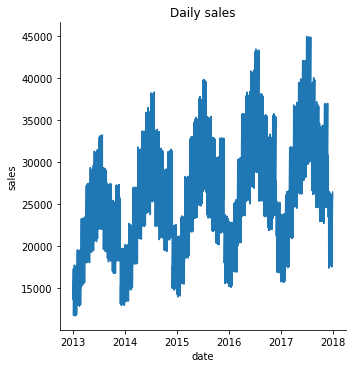

In [10]:
sns.relplot(x='date',y='sales',data=daily_sales,kind='line')
plt.title('Daily sales')

Text(0.5, 1.0, 'Store daily sales')

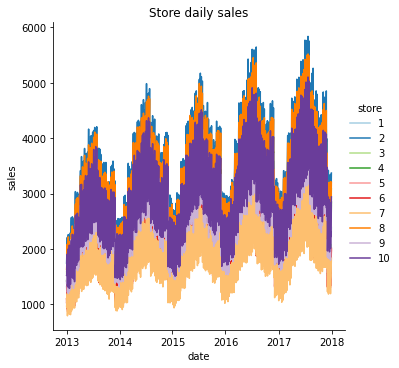

In [11]:
sns.relplot(x='date',y='sales',hue='store',data=store_daily_sales,kind='line',palette=sns.color_palette("Paired",10))
plt.title('Store daily sales')

Text(0.5, 1.0, 'Item daily sales')

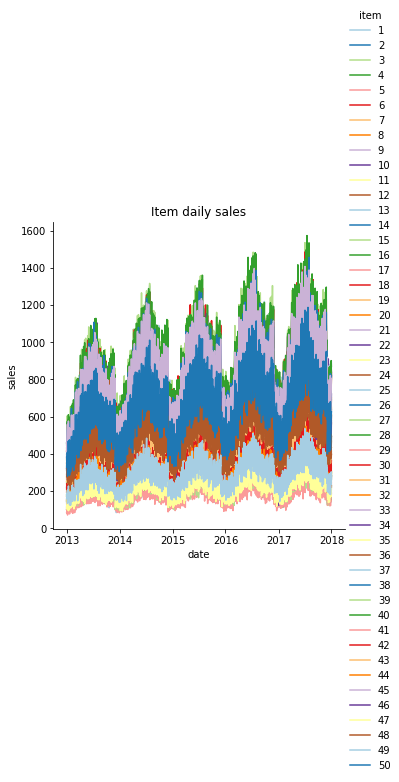

In [12]:
sns.relplot(x='date',y='sales',hue='item',data=item_daily_sales,kind='line',palette=sns.color_palette("Paired",50))
plt.title('Item daily sales')

In [13]:
# train data
train_data = train[(train['date'] >= '2017-01-01')]

In [14]:
train_gp = train_data.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head(33)

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0
5,1,1,2017-01-06,24.0
6,1,1,2017-01-07,14.0
7,1,1,2017-01-08,20.0
8,1,1,2017-01-09,18.0
9,1,1,2017-01-10,11.0


## Transforme from time series to supervised  

In [15]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
window = 29
lag =90
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0


In [17]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]


In [18]:
series

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182405,50.0,10.0,79.0,50.0,10.0,89.0,50.0,10.0,96.0,50.0,...,79.0,50.0,10.0,80.0,50,10,82.0,50.0,10.0,63.0
182406,50.0,10.0,89.0,50.0,10.0,96.0,50.0,10.0,92.0,50.0,...,80.0,50.0,10.0,82.0,50,10,90.0,50.0,10.0,59.0
182407,50.0,10.0,96.0,50.0,10.0,92.0,50.0,10.0,102.0,50.0,...,82.0,50.0,10.0,90.0,50,10,103.0,50.0,10.0,74.0
182408,50.0,10.0,92.0,50.0,10.0,102.0,50.0,10.0,60.0,50.0,...,90.0,50.0,10.0,103.0,50,10,99.0,50.0,10.0,62.0


In [19]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [20]:
series

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
29,19.0,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,...,21.0,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9.0,33.0
30,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,...,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0
31,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,...,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,21.0
32,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,...,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,29.0
33,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,16.0,...,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,24.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182405,79.0,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,...,72.0,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82.0,63.0
182406,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,...,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90.0,59.0
182407,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,...,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103.0,74.0
182408,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,74.0,...,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103.0,99.0,62.0


## Train test split

In [21]:
# Label
labels_col = 'sales(t+%d)' % lag
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,...,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114.0
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,...,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37.0
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,...,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49.0
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,...,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132.0
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,...,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62.0


## CNN for Time Series Forecasting

In [22]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [23]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error

In [24]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                44850     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
_________________________________________________________________


In [25]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=20, verbose=2)

Epoch 1/20
3149/3149 - 8s - loss: 415.7193 - val_loss: 419.6157
Epoch 2/20
3149/3149 - 8s - loss: 387.5724 - val_loss: 377.9467
Epoch 3/20
3149/3149 - 7s - loss: 373.2456 - val_loss: 372.2357
Epoch 4/20
3149/3149 - 7s - loss: 366.3947 - val_loss: 359.2323
Epoch 5/20
3149/3149 - 7s - loss: 362.8951 - val_loss: 382.8170
Epoch 6/20
3149/3149 - 7s - loss: 361.0230 - val_loss: 355.5959
Epoch 7/20
3149/3149 - 7s - loss: 360.1443 - val_loss: 354.8028
Epoch 8/20
3149/3149 - 7s - loss: 360.2798 - val_loss: 354.7019
Epoch 9/20
3149/3149 - 8s - loss: 358.2053 - val_loss: 366.5231
Epoch 10/20
3149/3149 - 7s - loss: 356.9080 - val_loss: 355.5156
Epoch 11/20
3149/3149 - 7s - loss: 355.6540 - val_loss: 353.0387
Epoch 12/20
3149/3149 - 8s - loss: 355.1142 - val_loss: 354.6259
Epoch 13/20
3149/3149 - 7s - loss: 354.8662 - val_loss: 349.2088
Epoch 14/20
3149/3149 - 7s - loss: 353.3183 - val_loss: 360.6807
Epoch 15/20
3149/3149 - 8s - loss: 352.5247 - val_loss: 353.3696
Epoch 16/20
3149/3149 - 8s - loss:

In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [27]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=20, verbose=2)

Epoch 1/20
3149/3149 - 35s - loss: 1783.5399 - val_loss: 547.8040
Epoch 2/20
3149/3149 - 33s - loss: 499.5656 - val_loss: 414.1204
Epoch 3/20
3149/3149 - 33s - loss: 383.0995 - val_loss: 375.1573
Epoch 4/20
3149/3149 - 32s - loss: 373.7586 - val_loss: 363.8684
Epoch 5/20
3149/3149 - 34s - loss: 372.7816 - val_loss: 409.1364
Epoch 6/20
3149/3149 - 32s - loss: 370.7010 - val_loss: 398.8883
Epoch 7/20
3149/3149 - 35s - loss: 368.6102 - val_loss: 382.7397
Epoch 8/20
3149/3149 - 33s - loss: 363.6293 - val_loss: 346.5963
Epoch 9/20
3149/3149 - 32s - loss: 363.7304 - val_loss: 349.4931
Epoch 10/20
3149/3149 - 34s - loss: 353.3676 - val_loss: 349.3504
Epoch 11/20
3149/3149 - 34s - loss: 348.8790 - val_loss: 344.2718
Epoch 12/20
3149/3149 - 34s - loss: 581.7492 - val_loss: 516.8471
Epoch 13/20
3149/3149 - 33s - loss: 494.8668 - val_loss: 521.3536
Epoch 14/20
3149/3149 - 34s - loss: 482.0725 - val_loss: 468.4564
Epoch 15/20
3149/3149 - 32s - loss: 447.5037 - val_loss: 422.6109
Epoch 16/20
3149/3

Text(0, 0.5, 'MSE')

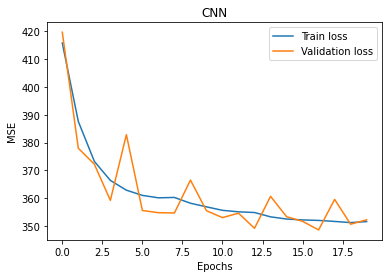

In [31]:
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('CNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

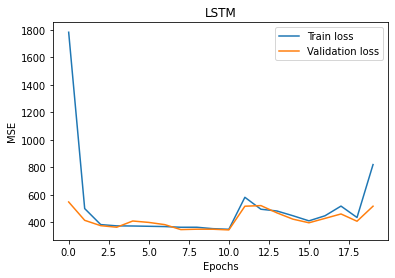

In [32]:
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')